

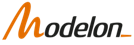

In [1]:
import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import pandas as pd

from datetime import datetime

import os
 
resPath = str('./Results/')
if not os.path.exists(resPath):
    os.mkdir(resPath)
    print("Folder %s created!" % resPath)

In [2]:
from modelon.impact.client import Client
client = Client(url="https://impact.modelon.cloud/", interactive=True)

In [3]:
workspaceName = "seminar2023"
modelName = "ModelicaSeminar.Seminar06.EVThermal.Experiments.Rev15System_File"

In [4]:
workspace = client.get_workspace(workspaceName)
model = workspace.get_model(modelName)
dynamic = workspace.get_custom_function("dynamic")

In [5]:
from modelon.impact.client import Range

exp_name = ['Charge at Winter', 'Drive at Winter']
kpi_results=['battery.volume.summary.T', 'motor.volume.summary.T', 'cabin.volume.summary.T']
kpi_para=['PTCBattery.size_factor_battery.k', 'PTCCabin.size_factor_cabin.k']
sim_time = [36000, 3600]

modifer = [{'PTCBattery.size_factor_battery.k': Range(0.1,0.9,9), 'T_start': 273.15, 
          'controller.fileName': 'Modelica.Utilities.Files.loadResource("modelica://ModelicaSeminar/Resources/Data/Controls1_Scenario3.txt")',
          'scenarioController_File.fileName': 'Modelica.Utilities.Files.loadResource("modelica://ModelicaSeminar/Resources/Data/Cooling1_Scenario3.txt")'},
          {'PTCCabin.size_factor_cabin.k':Range(1,51,6), 'T_start': 273.15, 
          'controller.fileName': 'Modelica.Utilities.Files.loadResource("modelica://ModelicaSeminar/Resources/Data/Controls1_Scenario2.txt")',
          'scenarioController_File.fileName': 'Modelica.Utilities.Files.loadResource("modelica://ModelicaSeminar/Resources/Data/Cooling1_Scenario2.txt")'}]

In [6]:
def exp(exp_name, modify, stop_time, para_name, kpi_results):
    print("experiment with parameter sweep: "+str(exp_name))
    print()
    # set up simulation
    experiment_def = model.new_experiment_definition(dynamic.with_parameters(start_time=0, final_time=stop_time))
    exp_def = experiment_def.with_modifiers(modify)
    exp = workspace.execute(exp_def).wait()
    # run simulation
    expRes=[]
    cases = exp.get_cases()
    for case in cases:
        if not case.is_successful():
            print(str(case.id)+": Simulation Failed, No results")
            log = case.get_log()
            log.show()
        else:
            result = case.get_trajectories()
            expRes.append(result)
            print (str(case.id)+': Simulation Done, '+str(para_name)+'='+str(result[para_name][-1]))
            
    fig = go.FigureWidget()
    dash = ['solid', 'dash', 'dot']
            
    data = []
    index_name = []
    now = datetime.now()
    
    for i in range(len(cases)):
        
        if not cases[i].is_successful():
            print( )
        else:
            x = np.array(expRes[i]['time'])/3600
                
            for j in range(len(kpi_results)):
                y = np.array(expRes[i][kpi_results[j]])-273.15
                name = str(kpi_results[j])+'_case_' + str(i+1)
                   
                fig.add_scatter(x = x, y = y, name = name, line=dict(width=2, dash =dash[j]))
                
                data.append(y)
                index_name.append(name)
                df = pd.DataFrame(data, index=index_name).T
                df.to_csv('./Results/'+str(exp_name)+'_'+str(now)+'.csv')  
            
    fig.update_yaxes(title_text="Temperature [degC]")
    fig.update_xaxes(title_text='Time [h]',showgrid=False) 
    fig.update_layout(height=500, showlegend=True)
    fig.show() 

experiment with parameter sweep: Charge at Winter

case_1: Simulation Done, PTCBattery.size_factor_battery.k=0.1
case_2: Simulation Done, PTCBattery.size_factor_battery.k=0.2
case_3: Simulation Done, PTCBattery.size_factor_battery.k=0.30000000000000004
case_4: Simulation Done, PTCBattery.size_factor_battery.k=0.4
case_5: Simulation Done, PTCBattery.size_factor_battery.k=0.5
case_6: Simulation Done, PTCBattery.size_factor_battery.k=0.6
case_7: Simulation Done, PTCBattery.size_factor_battery.k=0.7000000000000001
case_8: Simulation Done, PTCBattery.size_factor_battery.k=0.8
case_9: Simulation Done, PTCBattery.size_factor_battery.k=0.9


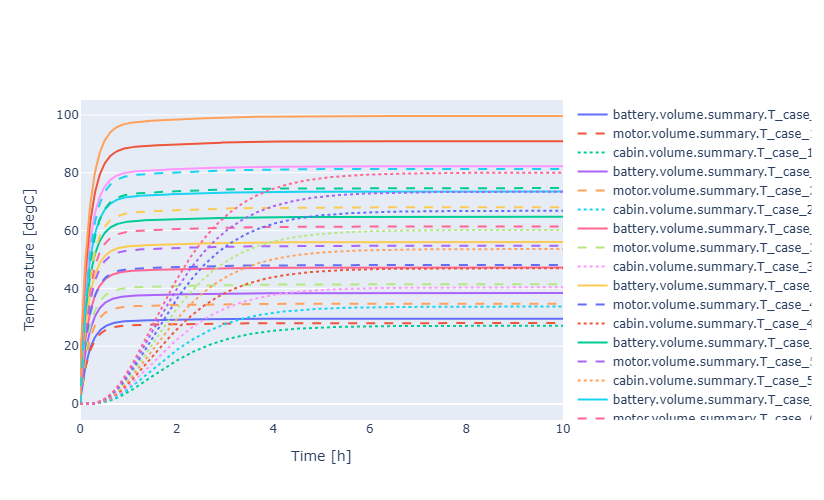

experiment with parameter sweep: Drive at Winter

case_1: Simulation Done, PTCCabin.size_factor_cabin.k=1.0
case_2: Simulation Done, PTCCabin.size_factor_cabin.k=11.0
case_3: Simulation Done, PTCCabin.size_factor_cabin.k=21.0
case_4: Simulation Done, PTCCabin.size_factor_cabin.k=31.0
case_5: Simulation Done, PTCCabin.size_factor_cabin.k=41.0
case_6: Simulation Done, PTCCabin.size_factor_cabin.k=51.0


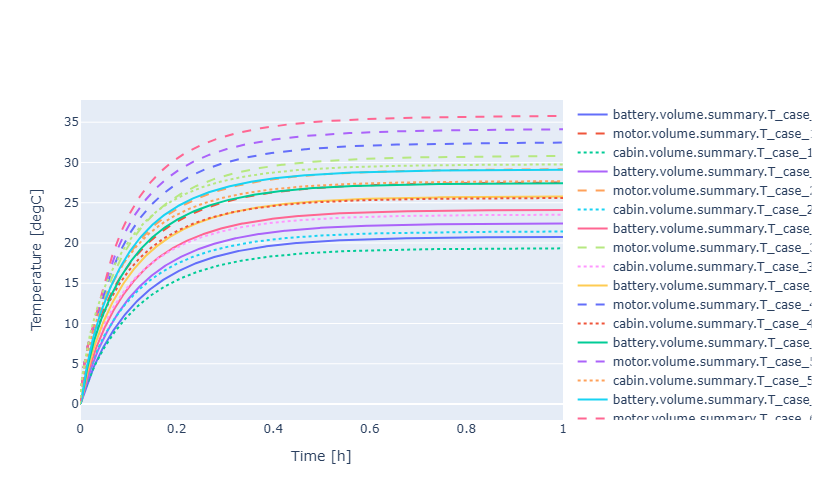

In [7]:
for i in range(len(exp_name)):
    exp(exp_name[i], modifer[i], sim_time[i] , kpi_para[i], kpi_results)

## Clean up workspace

In [8]:
experiments = workspace.get_experiments()
fmus = workspace.get_fmus()

for experiment in experiments:
    experiment.delete()

for fmu in fmus:
    fmu.delete()



**YOUR EXPERT PARTNER IN SYSTEMS MODELING AND SIMULATION**
<br>
support@modelon.com | www.modelon.com | www.help.modelon.com 
<br>
*©2023 Modelon. All Rights Reserved.*